## Download data from NORA3 and save to ncfile

The following codes is a guide to download data from the NWP NORA3 at a chosen time period and save it as an nc-file. 
Data available at https://thredds.met.no/thredds/projects/nora3.html. This script use the files ending with fp.nc 


- Several variables available. 
- Containing wind_speed and wind_direction at 10m data from chosen dates and save it to an ncfile.

choose a datespan (years, months, day) and save it as a ncfile.

Data available from: 1969.08.01 to current date, check link for latest date

Model runs 4 times a day, every 6h, the files contains hourly updated data based on these runs

In [47]:
# Importing necessary modules

import xarray as xr
import numpy as np

import netCDF4 as nc
import matplotlib.pylab as plt
import pandas as pd

import pyproj
import datetime as dt
from datetime import date, timedelta

In [48]:
"""
The coordinates in get_coordinates is at the center of the offshore wind sites
"""

def get_coordinates_center_OWS(location_name):
    locations = {
        'Nordavind_A': {
            'latitude': 71.1314956,
            'longitude': 32.048109
        },
        'Nordavind_B': {
            'latitude': 71.7880587,
            'longitude': 27.7221338
        },
        'Nordavind_C': {
            'latitude': 71.7471898,
            'longitude': 19.9808019
        },
        'Nordavind_D': {
            'latitude': 71.473272,
            'longitude': 18.7614613
        },
        'Utsira_nord': {
            'latitude': 59.2740869,
            'longitude': 4.5441279
        },
        'Sørlige_nordsjø_2': {
            'latitude': 59.7894747,
            'longitude': 4.9314619
        }
    }

    if location_name in locations:
        coordinates = locations[location_name]
        return coordinates['latitude'], coordinates['longitude']
    else:
        return None


## Seklima station information retrival with frost api 

[Link to frost webpage](https://frost.met.no/index.html)

1. Create client id for yourself 
    * [Create client id here](https://frost.met.no/auth/requestCredentials.html)
    
This is used to retrive the longitude and latitude

In [ ]:
# Insert your own client ID here
client_id = 'insert client ID'

In [ ]:
'''
Getting the data for the meta dataframe

Using the frost api for seklima
'''

endpoint = 'https://frost.met.no/sources/v0.jsonld'

# Dictionary with elements to retrieve
parameters = {
    'fields': 'name,id,geometry,masl,validFrom'
}

# Issue an HTTP GET request
r = requests.get(endpoint, parameters, auth=(client_id,''))
# Extract JSON data
json = r.json()

# Check if the request worked, print out any errors
if r.status_code == 200:
    data_exp = json['data']
    print('Data retrieved from frost.met.no!')
else:
    print('Error! Returned status code %s' % r.status_code)
    print('Message: %s' % json['error']['message'])
    print('Reason: %s' % json['error']['reason'])

In [ ]:
'''
Transforming the data from a raw json format retrieved by requests 
to a pandas df format

When redefining the query the new columns need to be spesified for the dataframe df
'''

meta_df = pd.DataFrame(columns=['id', 'name', 'lon', 'lat', 'heigh-asl (m)','operating period (from)'])
ignored_values = 0
for i in range(len(data_exp)):
    row = []
    try:
        row.append(data_exp[i]['id'])
        row.append(data_exp[i]['name'])
        row.append(data_exp[i]['geometry']['coordinates'][0])
        row.append(data_exp[i]['geometry']['coordinates'][1])
        row.append(data_exp[i]['masl'])
        row.append(data_exp[i]['validFrom'])
        meta_df.loc[len(meta_df)] = row
    except:
        ignored_values += 1
        continue


print(f'Number of discarded values {ignored_values}')

# Setting the station id as row index2
meta_df = meta_df.set_index('id')

display(meta_df)

- Change station ID to match measurement station to get station coordinates
    * Find station ID at ([stations](https://seklima.met.no/stations/))
 
or 

- Insert site_name to get coordinates from center of OWS

In [ ]:

#################


station_id = "SN76956" # insert station ID, ex: 'SN76956' Goliat ,  'SN20926' hjelmsøybanken  ,   SN76926 Sleipner


################

longitude = meta_df.loc[f"{station_id}"]["lon"]
latitude = meta_df.loc[f"{station_id}"]["lat"]

print(f"{station_id}: longitude = {longitude}, latitude = {latitude}")

In [49]:
# insert the site name you want the data extracted from

################

site_name = 'Nordavind_C'

################

latitude, longitude = get_coordinates_center_OWS(site_name) # gets the latitude and longitude of the chosen site
print(f"{site_name}: longitude = {longitude}, latitude = {latitude}")

In [ ]:
# Choose latitude, longitude

latitude = 
longitude = 

## Projecting coordinates
Starts by projecting the chosen Latitude and Longitude coordinate to x and y cooridnates used in the model
- No changes needed in this part

In [50]:
"""
load in a random file from the NORA3 dataset, this is just used to project latitude/longitude to the correspinding 
x- and y-coordinate 
"""
year =  "2022"
month = "01"
day = "01"
hour = "00"


filename = f"https://thredds.met.no/thredds/dodsC/nora3/{year}/{month}/{day}/{hour}/fc{year}{month}{day}{hour}_003_fp.nc"
ncfile   = nc.Dataset(filename)


#######
# Projection
crs_NORA = pyproj.CRS.from_cf(
         {
            "grid_mapping_name": "lambert_conformal_conic",
            "standard_parallel": [66.3, 66.3],
            "longitude_of_central_meridian": -42.0,
            "latitude_of_projection_origin": 66.3,
             "earth_radius": 6371000.0,
         }
)

# Transformer to project from ESPG:4368 (WGS:84) to our lambert_conformal_conic
proj = pyproj.Transformer.from_crs(4326,crs_NORA,always_xy=True)
# Compute projected coordinates of lat/lon point
# Coordinates for OWS chosen earlyer
lat = latitude #N
lon = longitude #E
X,Y = proj.transform(lon,lat)

# Find nearest neighbour
x = ncfile.variables["x"][:]
y = ncfile.variables["y"][:]

Ix = np.argmin(np.abs(x - X)) # Nearest neighbour to LON 
Iy = np.argmin(np.abs(y - Y)) # Nearest neighbour to LAT 

ncfile.close()

In [ ]:

filename = f"https://thredds.met.no/thredds/dodsC/nora3/{year}/{month}/{day}/{hour}/fc{year}{month}{day}{hour}_003_fp.nc"
ncfile   = nc.Dataset(filename)


# Check variables in file
for variable in ncfile.variables:
    print(variable)
    
ncfile.close()

## Collecting the data 
In this section you can choose "start date" and "end date" for the timeperiod of data to be extracted. Different variables can also be left out or added before running the code. The dataset "fp.nc" contains temperature at 2m, wind speed and direction at 10m and surface air pressure. (run the for-loop in cell 2, to see all available variables) 

collecting time, wind speed (10m) and wind direction (10m) hourly data for 6 months approx: 55 min. 

In [51]:
"""
Choose start and end date
"""
start_date = date(2019, 1, 1) # choose start date (year, month, day)
end_date = date(2019, 1, 2) # choose end date (year, month, day)


delta = timedelta(days=1) # delta (timestep), initilly set to 1 day


"""
Create empty lists for each variable to be extracted 
"""
time = []
air_temp_2m=[]
wind_speed = [] # only at 10m
wind_direction = [] # only at 10m
surface_air_pressure = []

x_wind_z = []
y_wind_z = []

z = 0 # chose index for x- and y-wind height, 0 = 20m, 1 = 50m, 2 = 100m, 3 = 250m, 4 = 500m, 5 = 750m 



hours = ["00", "06", "12", "18"] # each day have one file with timestamp
leadtime = ["003","004","005","006","007","008"] #"009" if run with 009, this is the same as first in new set. for each timestamp an 3h update

while start_date <= end_date:

    y = start_date.strftime("%Y")
    m = start_date.strftime("%m")
    d = start_date.strftime("%d")
    for i1 in hours:
        for i2 in leadtime:
            opendap_url = f"https://thredds.met.no/thredds/dodsC/nora3/{y}/{m}/{d}/{i1}/fc{y}{m}{d}{i1}_{i2}_fp.nc"
            ncfile = nc.Dataset(opendap_url)
            
            times = ncfile.variables["time"][:] # only one timestamp for each file
            airtemp2m = ncfile.variables["air_temperature_2m"][0, 0, Iy, Ix] #[time(fixed), height(fixed), y, x]
            speed = ncfile.variables["wind_speed"][0, 0, Iy, Ix]
            direction = ncfile.variables["wind_direction"][0, 0, Iy, Ix]
            sur_p = ncfile.variables["surface_air_pressure"][0, 0, Iy, Ix]
            
            # xwind_z = ncfile.variables["x_wind_z"][0, z, Iy, Ix] 
            # ywind_z = ncfile.variables["y_wind_z"][0, z, Iy, Ix] 
            
            time.append(times)
            air_temp_2m.append(airtemp2m)
            wind_speed.append(speed)
            wind_direction.append(direction)
            surface_air_pressure.append(sur_p)
            
            # x_wind_z.append(xwind_z)
            # y_wind_z.append(ywind_z)
            
            ncfile.close()
       
    start_date += delta

## Dictionary
The output from gathering the chosen data is stored in lists. This section creates an dictionary and uses pandas to store in a easy-reference system
- Changes can be made in the dictionary "d_data" if variables is ignored or added

In [52]:
# create a dictionary and give name to the lists
d_data = {
     "time" : time, 
     "air_temperature_2m": air_temp_2m,
     "surface_pressure": surface_air_pressure,
     "wind_speed": wind_speed,
     "wind_direction": wind_direction,
    # "x_wind_z": x_wind_z,
    # "y_wind_z": y_wind_z
}

# convert to pandas dataframe
import pandas as pd

weather_data = pd.DataFrame.from_dict(d_data)
#print(weather_data)

## Save as NC-file
Define a function that saves the "weather_data" as an nc-file. 
- Change the output_filename to desired new saved filename

Filesize for time, wind speed and wind direction for 6 months: 93 KB

In [ ]:
"""
This code is an easy option saving the new file directly in the same directory as the working directory
"""

def save_dataframe_to_netcdf(dataframe, output_file):
    dataset = xr.Dataset(data_vars=dataframe.to_dict('series'))
    dataset.to_netcdf(output_file)

    print(f"Data saved successfully to {output_file}.")

output_filename = 'weather_data_NORA3.nc' #choose filename: default: "weather_data_NORA3.nc"
save_dataframe_to_netcdf(weather_data, output_filename)

In [ ]:
"""
This code makes a new optional directory at a desired location and saves the new file in this new directory.
If the directory already exist it will just save the new file in that directory. This way different ncfiles can be saved
in the same directory by keeping the same directory name and changing only the output_filename
"""

import os

# New directory 
directory = "weather_data"
  
# Parent Directory path 
parent_dir = "C:/Users/Ida/"

# Filename new ncfile
# {site_name} or {station_id}
output_filename = f'{station_id}_full_weather_data_NORA3.nc' # choose filename


# Path 
path = os.path.join(parent_dir, directory) 
  
# Create the directory if not already existing
if not os.path.isdir(path):
    os.mkdir(path)


def save_dataframe_to_netcdf(dataframe, output_file):
    dataset = xr.Dataset(data_vars=dataframe.to_dict('series'))
    output_path = f"{parent_dir}{directory}/{output_file}"
    dataset.to_netcdf(output_path)

    print(f"Data saved successfully to {output_path}.")


save_dataframe_to_netcdf(weather_data, output_filename)

## Examples on how to use the new NC-file

In [54]:
# open the new file 

filename = "weather_data_NORA3.nc"
ncfile = nc.Dataset(filename)


# print all variables in the file
for variable in ncfile.variables:
    print(variable)


dim_0
time
wind_speed
wind_direction


In [ ]:
# covert timestamps into nice readable dates

time = ncfile.variables["time"][:]

ts = np.linspace(0,len(time)-1,len(time))

nice_time = []


for i in range(0,len(ts)):
    tid = dt.datetime.utcfromtimestamp(time[i])
    nice_time.append(tid)


In [56]:
# extract variables
ws = ncfile.variables["wind_speed"][:]
direction = ncfile.variables["wind_direction"][:] 



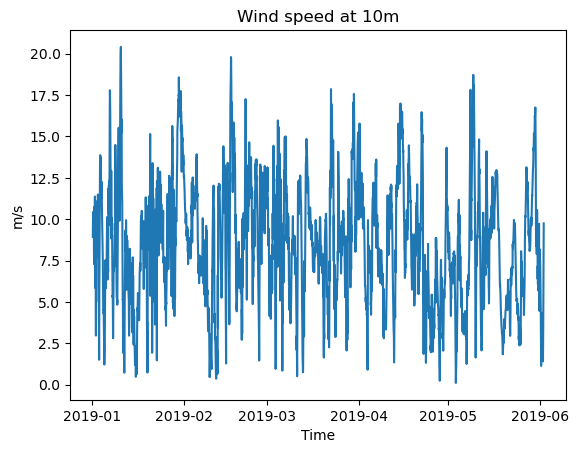

In [57]:
plt.plot(nice_time, ws)
plt.title("Wind speed at 10m")
plt.ylabel("m/s")
plt.xlabel("Time")

plt.tick_params(axis='x', labelcolor='black', labelrotation=75, labelsize=10)
plt.show()

# Histogram
This is an example on how to make a histogram from the wind speeds

Text(0.5, 1.0, 'Weibull distribution of wind speed at Nordavind_A')

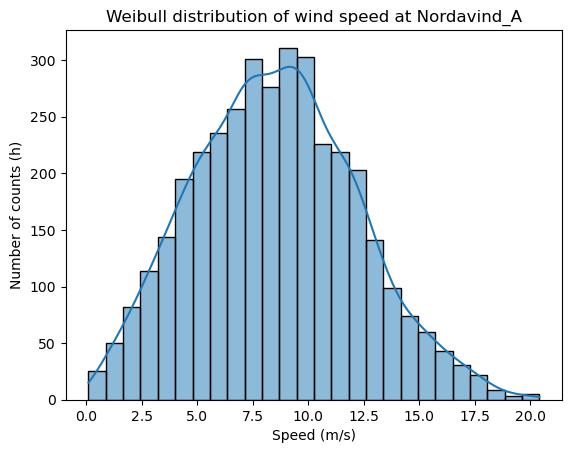

In [60]:
#install the seaborn package by removing the "#" and running the code below 
#!pip3 install seaborn

import seaborn as sns

sns.histplot(data = ncfile, x = ws, kde = True, bins = 26)
plt.xlabel("Speed (m/s)")
plt.ylabel("Number of counts (h)")
plt.title(f"Weibull distribution of wind speed at {site_name}")


# Windrose
the following example show how to make a windrose at the chosen site and timespan. The windrose illustrates the distribution of wind speed and direction together. The direction in degrees is transformed into cardinal directions, 360 - N, 180 - S, 90 - E, 270 - W  

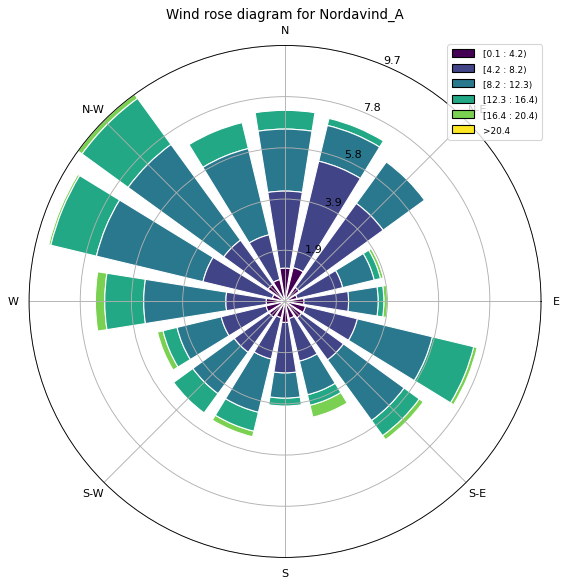

In [59]:
# run the code below if not already installed the windrose package 
#!pip3 install windrose

from windrose import WindroseAxes

speed = ncfile.variables["wind_speed"][:]
direction = ncfile.variables["wind_direction"][:] 

ax = WindroseAxes.from_ax()
ax.bar(direction,
       speed,
       normed=True, #get % of number of hours
       opening= 0.8, #width of bars
       edgecolor='white')
ax.set_legend(loc = "best")
plt.title(f"Wind rose diagram for {site_name}")
plt.show()
